The purpose of this notebook is to develop and test a model that is capable of predicting Field Failure Modes based on free text and multiple choice fields populated at Service Centers. This allows better aggregation of issues and more efficient problem solving.

In [1]:
#natural language processing to predict field failure modes

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.grid_search import GridSearchCV

In [3]:
stemmer = SnowballStemmer('english')

In [4]:
#define fuctions, try excluding stop words here (doesn't work below)

def word_tokenize(text, how = 'lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize() for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
def spelling(text):
    words = TextBlob(text).words
    return [word.correct() for word in words]

Data exploration results show how many claims do not have a Failure Mode assigned. This is because the sheer number of claims coming through each day as well as a lack of Engineering bandwidth to manually assign Failure Modes. The chart below illustrates this distribution.

In [5]:
#read in csv file for all since 2016-01-01 (we weill not be using this dataset for the model)

df_all = pd.read_csv('C:\Users\sglembocki\Documents\Excel Files\FaultModeNaturalLanguageProcessing.csv')

In [6]:
df_all.head()

,IsNull,RepairOrderJobID
0,0,1064771
1,0,1064772
2,0,1064773
3,0,1372398
4,0,1377547


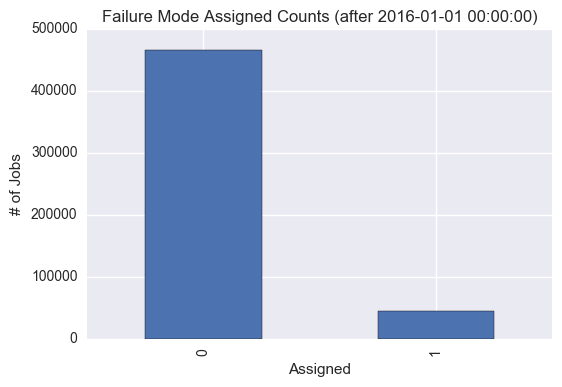

In [7]:
%matplotlib inline
df_all.IsNull.value_counts().plot(kind = 'bar', title = 'Failure Mode Assigned Counts (after 2016-01-01 00:00:00)')
plt.xlabel('Assigned')
plt.ylabel('# of Jobs')

In [8]:
#read in csv file

df = pd.read_csv('C:\Users\sglembocki\Documents\Excel Files\FaultModeNaturalLanguageProcessingRev4.csv')

In [9]:
#number of options (this is what we are predicting)

df['FaultModeID'].nunique()

3524

First, let's cleanse and parse the data. Below are some steps that are taken to do so:

- Claims that could potentially be in other languages have been excluded. This is because it contains the English version as well as the untranslated version which can throw off the Count Vectorizer.
- Unnecessary columns are removed from the DataFrame
- It is noted that the data is a bit sparse. Some claims contain NULL values in the free text fields which result in a NULL values when all columns are concatenated. These are removed from the DataFrame
- There is a fairly large tail of Failure Modes that have only been assigned once. These are removed to improve the predicition results for the more commonly occuring Failure Modes
- All free text and multiple choice fields are combined in one field for simplification
- There are special characters that are removed to improve the Count Vectorizer

*All of the steps above improve the accuracy of the model

In [10]:
#remove all claims that could potentially be non-english

df = df[df['Region'] != 'APAC']
df = df[df['Region'] != 'EU']
df = df[df['FaultModeID'] != 5388]
df = df[df['FailureMode'] != 'Unable to Duplicate Concern']

In [11]:
#delete unused fields

del df['Region']
del df['JobID']

In [12]:
df.head()

,Vin,ComplaintNarrative,CauseDescription,CauseNarrative,FaultModeID,FailureMode,RollupSymptom,CorrectionNarrative
14,5YJSA1H21FFP77752,Customer states: High Power Wall Connector (HP...,Inoperative,NaN,471,Wall Connector Pilot Fault,High Power Wall Connector (HPC) fails to charg...,Shipping High Power Wall Connector to customer...
20,5YJSA1H43FF081959,Customer states rear right door is leaking air...,Poorly Fitted,misaligned,346,Primary Seal Poor Fitment,Window seal leaks air/water,found glass to not be positioned on the correc...
25,5YJSA1H10FF081469,Customer states: Guest reports HPWC is failing...,NaN,NaN,470,Wall Connector Loose Crimp,High Power Wall Connector (HPC) fails to charg...,Provided guest with a new HPWC. Warranty excha...
27,5YJSA1H2XFF081410,Customer states: the passenger side visor does...,Distorted Warped / Bent,Sun visor retaining clip fatigued.,437,Sun Visor Clip Broken,Sun visor will not latch into hook,"Found passenger side sun visor clip fatigued, ..."
32,5YJSA1H2XFFP78740,"Customer states: vehicle has 3 alerts, will no...",Seized/Stiff/Sticking/Binding,Vehicle towed in with BMS_f152_SW_pos_contacto...,214,HV Contactor - Stuck,12v Battery Alert,Vehicle towed in with BMS_f152_SW_pos_contacto...


In [13]:
#drop NaN values

df = df.dropna()

In [14]:
df.head()

,Vin,ComplaintNarrative,CauseDescription,CauseNarrative,FaultModeID,FailureMode,RollupSymptom,CorrectionNarrative
20,5YJSA1H43FF081959,Customer states rear right door is leaking air...,Poorly Fitted,misaligned,346,Primary Seal Poor Fitment,Window seal leaks air/water,found glass to not be positioned on the correc...
27,5YJSA1H2XFF081410,Customer states: the passenger side visor does...,Distorted Warped / Bent,Sun visor retaining clip fatigued.,437,Sun Visor Clip Broken,Sun visor will not latch into hook,"Found passenger side sun visor clip fatigued, ..."
32,5YJSA1H2XFFP78740,"Customer states: vehicle has 3 alerts, will no...",Seized/Stiff/Sticking/Binding,Vehicle towed in with BMS_f152_SW_pos_contacto...,214,HV Contactor - Stuck,12v Battery Alert,Vehicle towed in with BMS_f152_SW_pos_contacto...
36,5YJSA1H28FFP78851,"Client reports persistent ""feedback crackle/hu...",Intermittent,"Intermittent, potential amp or model fault int...",60,Center Display Causing Audio Distortion,Audio Distortion,Test drove several times under various conditi...
37,5YJSA1H2XFFP73179,Customer states: Customer states that the Pano...,Incorrect Alignment,Positioning/alignment of glass panels with res...,317,Pano Roof Glass Poor Fitment,Panoramic roof will not open/ close,Moving glass catches the fixed glass seal maki...


In [15]:
#show count of total claims and claims that are unique failure modes (i.e. only have been assigned once)

vc = df.FailureMode.value_counts()

print vc.shape
print vc[vc != 1].shape #let's include these
print vc[vc == 1].shape #and exclude these

(2502L,)
(1394L,)
(1108L,)


In [16]:
values = pd.DataFrame(vc[vc > 1])
values.head() #these are the failure modes we want to include

,FailureMode
Falcon Door Inductive Sensors - Detect Object That Is Not Present,1120
Key Fob Battery - Replacement Required,1002
12v Battery - Replacement Required Alert,793
Front Door - Latch Fault,569
Falcon Door Ultrasonic Sensor - Detects Object That Is Not Present,537


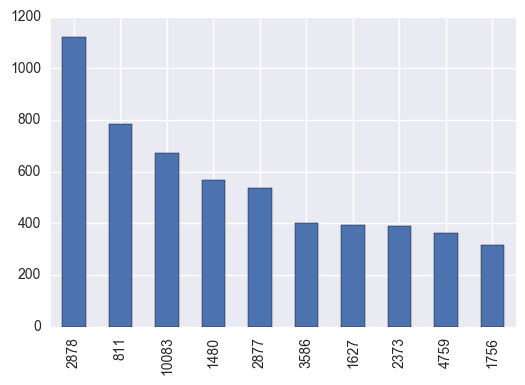

In [17]:
df.FaultModeID.value_counts().head(10).plot(kind = 'bar', stacked = True)

In [18]:
df = df[df['FailureMode'].isin(values.index.tolist())] #filter out data to include only those that occur more than once

In [19]:
#create a new field that combines all other features of interest

df['All'] = (df['ComplaintNarrative'] + ' ' + df['CauseDescription'] + ' ' + df['CauseNarrative'] + ' ' + df['RollupSymptom'] + df['CorrectionNarrative'])

In [20]:
df[df['FaultModeID'] != 5388].head()

,Vin,ComplaintNarrative,CauseDescription,CauseNarrative,FaultModeID,FailureMode,RollupSymptom,CorrectionNarrative,All
20,5YJSA1H43FF081959,Customer states rear right door is leaking air...,Poorly Fitted,misaligned,346,Primary Seal Poor Fitment,Window seal leaks air/water,found glass to not be positioned on the correc...,Customer states rear right door is leaking air...
27,5YJSA1H2XFF081410,Customer states: the passenger side visor does...,Distorted Warped / Bent,Sun visor retaining clip fatigued.,437,Sun Visor Clip Broken,Sun visor will not latch into hook,"Found passenger side sun visor clip fatigued, ...",Customer states: the passenger side visor does...
32,5YJSA1H2XFFP78740,"Customer states: vehicle has 3 alerts, will no...",Seized/Stiff/Sticking/Binding,Vehicle towed in with BMS_f152_SW_pos_contacto...,214,HV Contactor - Stuck,12v Battery Alert,Vehicle towed in with BMS_f152_SW_pos_contacto...,"Customer states: vehicle has 3 alerts, will no..."
36,5YJSA1H28FFP78851,"Client reports persistent ""feedback crackle/hu...",Intermittent,"Intermittent, potential amp or model fault int...",60,Center Display Causing Audio Distortion,Audio Distortion,Test drove several times under various conditi...,"Client reports persistent ""feedback crackle/hu..."
37,5YJSA1H2XFFP73179,Customer states: Customer states that the Pano...,Incorrect Alignment,Positioning/alignment of glass panels with res...,317,Pano Roof Glass Poor Fitment,Panoramic roof will not open/ close,Moving glass catches the fixed glass seal maki...,Customer states: Customer states that the Pano...


In [21]:
#decode feature column, remove special characters

df['CorrectionNarrativeRev2'] = df['All'].str.decode('utf-8', errors = 'ignore').str.lower() #decode and lowercase
df['CorrectionNarrativeRev2'] = df['CorrectionNarrativeRev2'].str.replace('"', '') #remove double quotes
df['CorrectionNarrativeRev2'] = df['CorrectionNarrativeRev2'].str.replace('\'', '') #remove single quotes
df['CorrectionNarrativeRev2'] = df['CorrectionNarrativeRev2'].str.replace('customer states:', '') #present in nearly all claims
df['CorrectionNarrativeRev2'] = df['CorrectionNarrativeRev2'].str.replace('customer states', '') #slight variation of above
df['CorrectionNarrativeRev2'] = df['CorrectionNarrativeRev2'].str.replace(' / ', ' ') #remove slashes
df['CorrectionNarrativeRev2'] = df['CorrectionNarrativeRev2'].str.replace('/', ' ') #remove slashes
df['CorrectionNarrativeRev2'] = df['CorrectionNarrativeRev2'].str.replace('.', ' ') #remove periods
df['CorrectionNarrativeRev2'] = df['CorrectionNarrativeRev2'].str.replace('\n', ' ')

In [22]:
df.head()

,Vin,ComplaintNarrative,CauseDescription,CauseNarrative,FaultModeID,FailureMode,RollupSymptom,CorrectionNarrative,All,CorrectionNarrativeRev2
20,5YJSA1H43FF081959,Customer states rear right door is leaking air...,Poorly Fitted,misaligned,346,Primary Seal Poor Fitment,Window seal leaks air/water,found glass to not be positioned on the correc...,Customer states rear right door is leaking air...,rear right door is leaking air he can push ...
27,5YJSA1H2XFF081410,Customer states: the passenger side visor does...,Distorted Warped / Bent,Sun visor retaining clip fatigued.,437,Sun Visor Clip Broken,Sun visor will not latch into hook,"Found passenger side sun visor clip fatigued, ...",Customer states: the passenger side visor does...,the passenger side visor doesnt latch properl...
32,5YJSA1H2XFFP78740,"Customer states: vehicle has 3 alerts, will no...",Seized/Stiff/Sticking/Binding,Vehicle towed in with BMS_f152_SW_pos_contacto...,214,HV Contactor - Stuck,12v Battery Alert,Vehicle towed in with BMS_f152_SW_pos_contacto...,"Customer states: vehicle has 3 alerts, will no...","vehicle has 3 alerts, will not start in wacon..."
36,5YJSA1H28FFP78851,"Client reports persistent ""feedback crackle/hu...",Intermittent,"Intermittent, potential amp or model fault int...",60,Center Display Causing Audio Distortion,Audio Distortion,Test drove several times under various conditi...,"Client reports persistent ""feedback crackle/hu...",client reports persistent feedback crackle hum...
37,5YJSA1H2XFFP73179,Customer states: Customer states that the Pano...,Incorrect Alignment,Positioning/alignment of glass panels with res...,317,Pano Roof Glass Poor Fitment,Panoramic roof will not open/ close,Moving glass catches the fixed glass seal maki...,Customer states: Customer states that the Pano...,that the panoramic roof does not open proper...


In [23]:
df[df['FaultModeID'] != 5388].head()

,Vin,ComplaintNarrative,CauseDescription,CauseNarrative,FaultModeID,FailureMode,RollupSymptom,CorrectionNarrative,All,CorrectionNarrativeRev2
20,5YJSA1H43FF081959,Customer states rear right door is leaking air...,Poorly Fitted,misaligned,346,Primary Seal Poor Fitment,Window seal leaks air/water,found glass to not be positioned on the correc...,Customer states rear right door is leaking air...,rear right door is leaking air he can push ...
27,5YJSA1H2XFF081410,Customer states: the passenger side visor does...,Distorted Warped / Bent,Sun visor retaining clip fatigued.,437,Sun Visor Clip Broken,Sun visor will not latch into hook,"Found passenger side sun visor clip fatigued, ...",Customer states: the passenger side visor does...,the passenger side visor doesnt latch properl...
32,5YJSA1H2XFFP78740,"Customer states: vehicle has 3 alerts, will no...",Seized/Stiff/Sticking/Binding,Vehicle towed in with BMS_f152_SW_pos_contacto...,214,HV Contactor - Stuck,12v Battery Alert,Vehicle towed in with BMS_f152_SW_pos_contacto...,"Customer states: vehicle has 3 alerts, will no...","vehicle has 3 alerts, will not start in wacon..."
36,5YJSA1H28FFP78851,"Client reports persistent ""feedback crackle/hu...",Intermittent,"Intermittent, potential amp or model fault int...",60,Center Display Causing Audio Distortion,Audio Distortion,Test drove several times under various conditi...,"Client reports persistent ""feedback crackle/hu...",client reports persistent feedback crackle hum...
37,5YJSA1H2XFFP73179,Customer states: Customer states that the Pano...,Incorrect Alignment,Positioning/alignment of glass panels with res...,317,Pano Roof Glass Poor Fitment,Panoramic roof will not open/ close,Moving glass catches the fixed glass seal maki...,Customer states: Customer states that the Pano...,that the panoramic roof does not open proper...


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22866 entries, 20 to 57558
Data columns (total 10 columns):
Vin                        22866 non-null object
ComplaintNarrative         22866 non-null object
CauseDescription           22866 non-null object
CauseNarrative             22866 non-null object
FaultModeID                22866 non-null int64
FailureMode                22866 non-null object
RollupSymptom              22866 non-null object
CorrectionNarrative        22866 non-null object
All                        22866 non-null object
CorrectionNarrativeRev2    22866 non-null object
dtypes: int64(1), object(9)
memory usage: 1.9+ MB


Before a model is developed it is important to note the NULL accuracy. If we were to guess the most commonly occurring Failure Mode then we would arrive at 4.9% accuracy. This will serve as a baseline when gauging the effectiveness of the the model(s).

In [25]:
#null accuracy

null = df.FailureMode.value_counts() / df.shape[0]
null.head()

Falcon Door Inductive Sensors - Detect Object That Is Not Present     0.048981
Key Fob Battery - Replacement Required                                0.043821
12v Battery - Replacement Required Alert                              0.034680
Front Door - Latch Fault                                              0.024884
Falcon Door Ultrasonic Sensor - Detects Object That Is Not Present    0.023485
Name: FailureMode, dtype: float64

Now it is time to develop our first model. Because of the structure and type of data the DataFrame includes, we begin with a Naive Bayes model. This is known to be a very fast model when predicting large text data sets. To prep our model, the data is sent through a Count Vectorizer and turned into a Document Term Matrix. When Count Vectorizing the data, we pass every term through a spell check and stemmer (found to be a bit more effective than lemmatizing). It is also useful to note that sending the terms through a spell check prior to the stemmer is VERY expensive. To evaluate the model, we will use both accuracy and roc_auc scores.

In [26]:
#split into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(df.CorrectionNarrativeRev2, df.FaultModeID, random_state = 1)

In [27]:
#learn the vocabulary of the training data

In [28]:
x_train.head()

32244     the spine roof applique has extremely rough e...
33534     passenger side falcon wing door stops 1-2 fee...
27450     there are water bubbles on his touchscreen   ...
15978     left falcon wing door is not properly aligned...
8596     door seal has poor fitment or are pulling away...
Name: CorrectionNarrativeRev2, dtype: object

In [29]:
#instantiate and fit count vectorizer (stop_words not working)

vect = CountVectorizer(stop_words = 'english', analyzer = lambda x: word_tokenize(x, how = 'stem')) #troubleshoot stop_words
x_train_dtm = vect.fit_transform(x_train)

In [31]:
#examine the vocabulary and document-term matrix together

train_arr = x_train_dtm.toarray()
train_features = vect.get_feature_names()
pd.DataFrame(x_train_dtm.toarray(), columns = vect.get_feature_names()).head()

,0,0-2,0-25mph,0-5mph,0-60mph,00,00-c,000,00012,000453,...,zealand,zepp,zero,zhang,zip,zipper,zkvc_xm8cw4,zone,zoom,zschall
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
x_test.head()

8787      falcon door does not open (right)  poor adhes...
9897     passenger side lift pads are missing   missing...
4874      front passenger side window has a wind noise ...
3178      customer stats that the vehicle cannot establ...
57150    alert appeared: 12v battery power low car may ...
Name: CorrectionNarrativeRev2, dtype: object

In [33]:
#transform testing data into a document term matrix

x_test_dtm = vect.transform(x_test)

In [34]:
pd.DataFrame(x_test_dtm.toarray(), columns = vect.get_feature_names()).head()

,0,0-2,0-25mph,0-5mph,0-60mph,00,00-c,000,00012,000453,...,zealand,zepp,zero,zhang,zip,zipper,zkvc_xm8cw4,zone,zoom,zschall
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#ensure columns match

print x_train_dtm.shape
print x_test_dtm.shape

(17149, 13261)
(5717, 13261)


In [36]:
#create df with count and token

x_train_token_counts = pd.DataFrame({'Token': train_features, 'Count': np.sum(train_arr, axis = 0)})
x_train_token_counts.sort_values(by = 'Count', ascending = False).head() #stop words still exist

,Count,Token
1944,64019,and
11781,58059,the
4650,55605,door
11907,47281,to
10114,29569,replac


In [37]:
#instantiate and fit the model

nb = MultinomialNB()
nb.fit(x_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [38]:
#let's check out our predicitons

predictions = nb.predict(x_test_dtm)
predictions

array([2877, 2877, 1774, ..., 3687, 1627, 5148], dtype=int64)

In [39]:
#model accuracy for all models

print metrics.accuracy_score(y_test, predictions)

0.369949274095


This is a relatively accurate model given the low NULL accuracy; however, it seems there is a lot of room for improvement. Before testing another model, let's try splitting the data by the type of car. Logic here is that many defects and issues will be specific to model. Below is a data set that contains VIN and ModelID and can be joined to the original DataFrame to split by model id. The Naive Bayes Model will be compared to the accuracy score from the combined model.

In [40]:
#generate new models based on vehicle model id

model = pd.read_csv('C:\Users\sglembocki\Documents\Excel Files\VinModel.csv')
model[model['ModelID'] == 1].head()

,Vin,ModelID
0,5YJSA1H26FF082988,1
1,5YJSA1E47FF108360,1
2,5YJSA1E26FF118733,1
3,5YJSA1H46FF093412,1
4,5YJSA7E28GF141290,1


In [41]:
model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214126 entries, 0 to 214125
Data columns (total 2 columns):
Vin        214126 non-null object
ModelID    214126 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


In [42]:
#join df with model and split into separate dataframes by model id

df_model = pd.merge(df, model, on = 'Vin', how = 'inner')
model_s = df_model[df_model['ModelID'] == 1]
model_x = df_model[df_model['ModelID'] == 2]

In [43]:
model_s.head()

,Vin,ComplaintNarrative,CauseDescription,CauseNarrative,FaultModeID,FailureMode,RollupSymptom,CorrectionNarrative,All,CorrectionNarrativeRev2,ModelID
0,5YJSA1H43FF081959,Customer states rear right door is leaking air...,Poorly Fitted,misaligned,346,Primary Seal Poor Fitment,Window seal leaks air/water,found glass to not be positioned on the correc...,Customer states rear right door is leaking air...,rear right door is leaking air he can push ...,1
1,5YJSA1H2XFF081410,Customer states: the passenger side visor does...,Distorted Warped / Bent,Sun visor retaining clip fatigued.,437,Sun Visor Clip Broken,Sun visor will not latch into hook,"Found passenger side sun visor clip fatigued, ...",Customer states: the passenger side visor does...,the passenger side visor doesnt latch properl...,1
2,5YJSA1H2XFF081410,Customer states: trim on back side of passenge...,Broken/Cracked/Damaged,Passenger front inner seat cushion trim fatigued.,7781,Cosmetic Damage,Seat bottom trim is coming off,Found front passenger inner cushion trim fatig...,Customer states: trim on back side of passenge...,trim on back side of passenger seat is coming...,1
3,5YJSA1H2XFFP78740,"Customer states: vehicle has 3 alerts, will no...",Seized/Stiff/Sticking/Binding,Vehicle towed in with BMS_f152_SW_pos_contacto...,214,HV Contactor - Stuck,12v Battery Alert,Vehicle towed in with BMS_f152_SW_pos_contacto...,"Customer states: vehicle has 3 alerts, will no...","vehicle has 3 alerts, will not start in wacon...",1
4,5YJSA1H28FFP78851,"Client reports persistent ""feedback crackle/hu...",Intermittent,"Intermittent, potential amp or model fault int...",60,Center Display Causing Audio Distortion,Audio Distortion,Test drove several times under various conditi...,"Client reports persistent ""feedback crackle/hu...",client reports persistent feedback crackle hum...,1


In [44]:
model_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5024 entries, 0 to 22865
Data columns (total 11 columns):
Vin                        5024 non-null object
ComplaintNarrative         5024 non-null object
CauseDescription           5024 non-null object
CauseNarrative             5024 non-null object
FaultModeID                5024 non-null int64
FailureMode                5024 non-null object
RollupSymptom              5024 non-null object
CorrectionNarrative        5024 non-null object
All                        5024 non-null object
CorrectionNarrativeRev2    5024 non-null object
ModelID                    5024 non-null int64
dtypes: int64(2), object(9)
memory usage: 471.0+ KB


In [45]:
model_x.head()

,Vin,ComplaintNarrative,CauseDescription,CauseNarrative,FaultModeID,FailureMode,RollupSymptom,CorrectionNarrative,All,CorrectionNarrativeRev2,ModelID
1119,5YJXCAE47GFF00002,Customer states: Liftgate will not open from t...,Firmware Fault,Error in firmware causing latch to not operate,2515,Liftgate - Does Not Respond To Open Command,Liftgate does not open/close properly,"Verified the concern, tested latch and found l...",Customer states: Liftgate will not open from t...,liftgate will not open from the touchscreen ...,2
1120,5YJXCAE47GFF00002,Customer states: Luggage compartment trim is d...,Distorted Warped / Bent,rear fascia garnish not secured to bumper,1892,Rear Fascia - Poor Fit,Rear fascia trim damaged,"Removed and replaced Rear Fascia garnish.,Remo...",Customer states: Luggage compartment trim is d...,luggage compartment trim is detached *on pass...,2
1121,5YJXCAE47GFF00002,Customer states: Falcon Door stops in mid moti...,Incorrect Adjustment,door striker out of adjustment.,4216,Falcon Door Latch - Will Not Cinch,Falcon Door will not fully close,"Verified customer complaint, excessive seal pr...",Customer states: Falcon Door stops in mid moti...,falcon door stops in mid motion while closin...,2
1122,5YJXCAE47GFF00002,Customer states: Side mirror tilt function not...,No Fault Found / Unable To Replicate,Not verified,1627,Customer Education,Side mirror adjustment issue,"Customer Education. While in reverse, adjusted...",Customer states: Side mirror tilt function not...,side mirror tilt function not working correct...,2
1123,5YJXCAE47GFF00002,Customer states: after opening the doors by to...,Firmware Fault,"Firmware issue, completed",5148,Key Fob - Not Communicating With Vehicle,Key FOB function problems,"Verified complaint, FW issue, recommend update...",Customer states: after opening the doors by to...,"after opening the doors by touch, the car wil...",2


In [46]:
model_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17842 entries, 1119 to 22861
Data columns (total 11 columns):
Vin                        17842 non-null object
ComplaintNarrative         17842 non-null object
CauseDescription           17842 non-null object
CauseNarrative             17842 non-null object
FaultModeID                17842 non-null int64
FailureMode                17842 non-null object
RollupSymptom              17842 non-null object
CorrectionNarrative        17842 non-null object
All                        17842 non-null object
CorrectionNarrativeRev2    17842 non-null object
ModelID                    17842 non-null int64
dtypes: int64(2), object(9)
memory usage: 1.6+ MB


In [47]:
#null accuracy

null = model_s.FailureMode.value_counts() / model_s.shape[0]
null.head()

12v Battery - Replacement Required Alert                  0.133957
Key Fob Battery - Replacement Required                    0.043591
Key Fob Buttons - Exposed                                 0.035828
Key Fob - Not Communicating With Vehicle                  0.031051
Bulletin (SB-16-32-001): Steering Wheel Clicking Noise    0.020303
Name: FailureMode, dtype: float64

In [48]:
x_train, x_test, y_train, y_test = train_test_split(model_s.CorrectionNarrativeRev2, model_s.FaultModeID, random_state = 1)

In [49]:
#instantiate count vectorizer (stop_words not working)

vect = CountVectorizer(stop_words = 'english', analyzer = lambda x: word_tokenize(x, how = 'stem')) #troubleshoot stop_words
x_train_dtm = vect.fit_transform(x_train)

In [50]:
x_test_dtm = vect.transform(x_test)

In [51]:
#fit the model

nb = MultinomialNB()
nb.fit(x_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [52]:
#let's check out our predicitons

predictions = nb.predict(x_test_dtm)
predictions

array([  260,   325, 10083, ...,   262,  8288,  3660], dtype=int64)

In [53]:
#model accuracy for model id == 1

print metrics.accuracy_score(y_test, predictions) #note that this is much better than when vehicles were combined

0.501592356688


Results show that the prediction model is much more accurate when split by vehicle model. Results show 50.2% accuracy which is a huge improvement from the 13.4% NULL accuracy. Next step is to try a different model (Logistic Regression) and validate using the same accuracy score metric. This model runs slower but could result in an accuracy improvement

In [65]:
#let's try logistic regression for model id == 1

logreg = LogisticRegression()
logreg.fit(x_train_dtm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
predictions = logreg.predict(x_test_dtm)
predictions

array([  260,   325, 10083, ...,   262,  3793,  3660], dtype=int64)

In [56]:
#model accuracy for model s using logistic regression

metrics.accuracy_score(y_test, predictions)

0.60270700636942676

In [62]:
#support vector machine

svm = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1e-3, n_iter = 5, random_state = 1)
svm.fit(x_train_dtm, y_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=1, shuffle=True, verbose=0,
       warm_start=False)

In [63]:
#model accuracy for support vector machine

predictions = svm.predict(x_test_dtm)
metrics.accuracy_score(y_test, predictions)

0.51512738853503182

In [66]:
#null accuracy

null = model_x.FailureMode.value_counts() / model_x.shape[0]
null.head()

Falcon Door Inductive Sensors - Detect Object That Is Not Present     0.062773
Key Fob Battery - Replacement Required                                0.043885
Front Door - Latch Fault                                              0.031891
Falcon Door Ultrasonic Sensor - Detects Object That Is Not Present    0.030098
Front Door Glass - Regulator Adjustment Required                      0.022475
Name: FailureMode, dtype: float64

In [67]:
x_train, x_test, y_train, y_test = train_test_split(model_x.CorrectionNarrativeRev2, model_x.FaultModeID, random_state = 1)

In [68]:
#instantiate count vectorizer (stop_words not working)

vect = CountVectorizer(stop_words = 'english', analyzer = lambda x: word_tokenize(x, how = 'stem')) #troubleshoot stop_words
x_train_dtm = vect.fit_transform(x_train)

In [69]:
x_test_dtm = vect.transform(x_test)

In [70]:
#fit the model

nb = MultinomialNB()
nb.fit(x_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [71]:
#let's check out our predictions

predictions = nb.predict(x_test_dtm)
predictions

array([2373, 6234, 2878, ..., 2878, 1747, 6116], dtype=int64)

In [72]:
#model accuracy for model id == 2

print metrics.accuracy_score(y_test, predictions)

0.422102667563


In [73]:
#let's try logistic regression for model id == 2

logreg = LogisticRegression()
logreg.fit(x_train_dtm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
predictions = logreg.predict(x_test_dtm)
predictions

array([2373, 6234, 2877, ..., 2878, 1747, 6116], dtype=int64)

In [75]:
metrics.accuracy_score(y_test, predictions)

0.54516924456399907

In [76]:
#support vector machines

svm = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1e-3, n_iter = 5, random_state = 1)
svm.fit(x_train_dtm, y_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=1, shuffle=True, verbose=0,
       warm_start=False)

In [77]:
predictions = svm.predict(x_test_dtm)
metrics.accuracy_score(y_test, predictions)

0.47657475902264068

Conclusion

Next Steps:

- Spelling corrections (very expensive)
- Grid search (also very expensive)
- Map failure modes to systems
- Further data cleansing

In [79]:
#pipeline

pipe = Pipeline([
  ('features', FeatureUnion([
        ('counts', CountVectorizer(analyzer = lambda x: word_tokenize(x, how = 'stem'))),
        ('tf_idf', TfidfVectorizer())])),
  ('classifier', LogisticRegression())
])

In [78]:
#parameter tuning using grid search

gram_range = [(1, n) for n in range(1, 3)]
param_grid = {
    'features__counts__ngram_range': gram_range
}
print param_grid

{'features__counts__ngram_range': [(1, 1), (1, 2)]}


In [89]:
#grid = GridSearchCV(pipe, param_grid, cv = 5, scoring = 'accuracy')

In [ ]:
#grid.fit(x_train, y_train)

In [80]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('counts', CountVectorizer(analyzer=<function <lambda> at 0x000000001A0533C8>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
      ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [94]:
mean = cross_val_score(pipe, x_train, y_train, cv = 5, scoring = 'accuracy').mean()
mean

C:\Users\sglembocki\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


0.54588455477489739